In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from combat.pycombat import pycombat
from scipy import stats
import statsmodels.stats.multitest as smm
import joblib
import networkx as nx
from matplotlib import cm
import seaborn as sns

dataset = pd.read_csv('../../Dataset/Merged/MergedDataset-136411.csv', index_col=0)
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
labels = dataset['Label']
dataset = dataset.drop(columns=['SampleID', 'Label'])

data = pycombat(dataset.transpose(), datasetID).transpose()
data['Label'] = labels

Found 6 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\samue\AppData\Roaming\Python\Python311\site-packages\combat\pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data


In [3]:
no_ms = data[data['Label'] == 0].drop(columns='Label')
ms = data[data['Label'] == 1].drop(columns='Label')

p_values = []
genes = ms.columns

for gene in genes:
    t_stat, p_val = stats.ttest_ind(no_ms[gene], ms[gene], equal_var=False)
    p_values.append(p_val)

# Correzione di Bonferroni
_, pvals_corrected, _, _ = smm.multipletests(p_values, alpha=0.05, method='bonferroni')

results = pd.DataFrame({
    'gene': genes,
    'p_value': p_values,
    'p_value_corrected': pvals_corrected
})

differentially_expressed_genes = results[results['p_value_corrected'] < 0.05]

print(differentially_expressed_genes)

            gene       p_value  p_value_corrected
89     RAB11FIP4  6.032962e-07       7.294454e-03
246       SEMA4D  7.672644e-07       9.276993e-03
463         NPM1  3.541931e-08       4.282549e-04
527     HLA-DRB1  4.347275e-07       5.256290e-03
656         GIT2  4.339215e-33       5.246544e-29
...          ...           ...                ...
11506     PABPC3  4.670090e-20       5.646606e-16
11812      LITAF  4.004452e-08       4.841783e-04
11841     PTPN11  6.898186e-12       8.340597e-08
11991   EEF1A1.1  1.111969e-13       1.344482e-09
12071     ARID1A  7.406658e-09       8.955390e-05

[63 rows x 3 columns]


In [3]:
diff_gene = differentially_expressed_genes['gene'].values
print(diff_gene)

['RAB11FIP4' 'SEMA4D' 'NPM1' 'HLA-DRB1' 'GIT2' 'PABPC1' 'CHST6' 'WWC3'
 'HPRT1' 'SLC25A3' 'ATP5MC3' 'ALDOA' 'ZKSCAN8' 'DHRS7' 'HEXA' 'EIF4EBP2'
 'KDM5B' 'TXNRD1' 'PIAS2' 'RPL4' 'AGK' 'GAPDH' 'PPIA' 'SRP72' 'DIAPH1'
 'RPL13A' 'RPS10' 'RPS15' 'TAPT1' 'EIF4G2' 'MACROH2A1' 'USP25' 'TMED5'
 'FLCN' 'LRRC59' 'TRMT5' 'SRSF9' 'HNRNPA1' 'IL24' 'VPS45' 'AKAP13' 'RFTN1'
 'NDUFA10' 'RPL28' 'RPL27A' 'UBR4' 'RPS28' 'LATS1' 'PKN2' 'P4HB' 'PSMB4'
 'SPATA1' 'RPL37A' 'RPS3' 'CYB5R1' 'VDAC2' 'FTH1P5' 'WIPI2' 'PABPC3'
 'LITAF' 'PTPN11' 'EEF1A1.1' 'ARID1A']


In [4]:
expl_summary = joblib.load('../../ShapValues/DatasetReduced/ensemble_summary.pkl')
ensemble_ablation = joblib.load("../../ShapValues/DatasetReduced/ensembleSoft_ablationScores.pkl")
ensemble_featureSelected = joblib.load('../../ShapValues/DatasetReduced/ensembleSoft_featureSelection.pkl')

Intersezione con migliori 100 LIME explanations

In [5]:
expl_best = list(dict(sorted(dict(zip(data.columns, expl_summary)).items(), key=lambda item: item[1], reverse=True)).keys())[:100]
resultExpl = set(differentially_expressed_genes['gene']).intersection(set(expl_best))
print(resultExpl)

{'HLA-DRB1', 'HNRNPA1', 'TRMT5', 'SEMA4D', 'GAPDH', 'EIF4EBP2', 'USP25', 'RPS10', 'PPIA', 'PABPC1', 'GIT2', 'RPS3', 'NPM1', 'UBR4', 'RPL13A', 'RPS28', 'RPL28'}


Intersezione con migliori 100 SHAP ensemble ridotto

In [7]:
shap_object = joblib.load('../../ShapValues/DatasetReduced/ensembleSelected_shapValues.pkl')
ensembleSelected = joblib.load('../../Modelli/DatasetReduced/ensembleSelected_373.pkl')
shap_values = shap_object.values
shap_importance = np.abs(shap_values).mean(0)
shap_dict = dict(zip(ensembleSelected.feature_names_in_, shap_importance))
expl_dictSummary = dict(zip(ensembleSelected.feature_names_in_, shap_importance))
expl_sorted = dict(sorted(expl_dictSummary.items(), key=lambda item: item[1], reverse=True))

print(set(differentially_expressed_genes['gene']).intersection(set(list(expl_sorted.keys())[:100])))

{'HLA-DRB1', 'HNRNPA1', 'TRMT5', 'TMED5', 'SEMA4D', 'GAPDH', 'USP25', 'SPATA1', 'PPIA', 'PABPC1', 'GIT2', 'RPS3', 'UBR4', 'EIF4EBP2', 'LRRC59', 'RPS28', 'RPL28'}


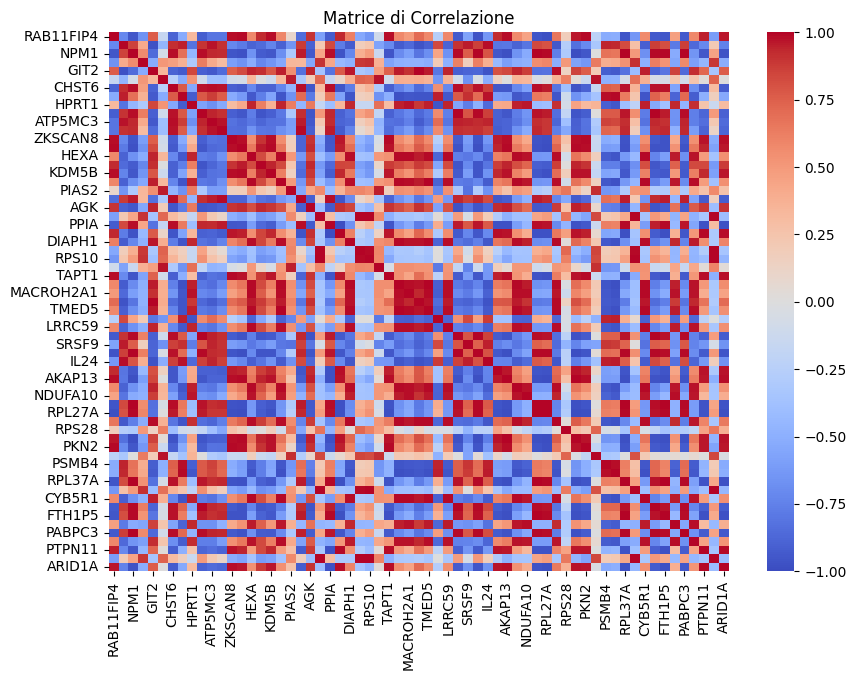

In [4]:
intersectCorr = dataset[differentially_expressed_genes['gene']].corr()

plt.figure(figsize=(10,7))
sns.heatmap(intersectCorr, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice di Correlazione')
plt.show()

In [5]:
ensemble_correlated_pairs = np.where(np.abs(intersectCorr) >= 0.75)

# Print the correlated pairs
for i, j in zip(ensemble_correlated_pairs[0], ensemble_correlated_pairs[1]):
    if i != j:
        print(f"{intersectCorr.index[i]} - {intersectCorr.columns[j]}: {intersectCorr.iloc[i, j]}")

RAB11FIP4 - NPM1: -0.9516364108143613
RAB11FIP4 - GIT2: 0.7642350511536256
RAB11FIP4 - CHST6: -0.8942045689781122
RAB11FIP4 - SLC25A3: -0.917168920539869
RAB11FIP4 - ATP5MC3: -0.8085205205480647
RAB11FIP4 - ALDOA: -0.8058353560298176
RAB11FIP4 - ZKSCAN8: 0.9824686488824668
RAB11FIP4 - DHRS7: 0.9866236661781921
RAB11FIP4 - EIF4EBP2: 0.9249118929025469
RAB11FIP4 - KDM5B: 0.9827342237704628
RAB11FIP4 - RPL4: -0.8512538248725683
RAB11FIP4 - AGK: 0.8987916810743698
RAB11FIP4 - PPIA: -0.9256625108957516
RAB11FIP4 - SRP72: 0.9369372119424125
RAB11FIP4 - TAPT1: 0.9779350480770891
RAB11FIP4 - TRMT5: -0.9345527696730096
RAB11FIP4 - HNRNPA1: -0.9615337498690417
RAB11FIP4 - VPS45: 0.9241922502758697
RAB11FIP4 - AKAP13: 0.9802312212815695
RAB11FIP4 - RPL28: -0.9566986645613187
RAB11FIP4 - RPL27A: -0.9767416802253541
RAB11FIP4 - LATS1: 0.9681763893114298
RAB11FIP4 - PKN2: 0.9858989446258799
RAB11FIP4 - RPL37A: -0.9549052618691725
RAB11FIP4 - VDAC2: -0.9366608337271017
RAB11FIP4 - FTH1P5: -0.95310189

C:\Users\samue\AppData\Local\Temp\ipykernel_33056\2513634623.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Coefficiente di Correlazione")


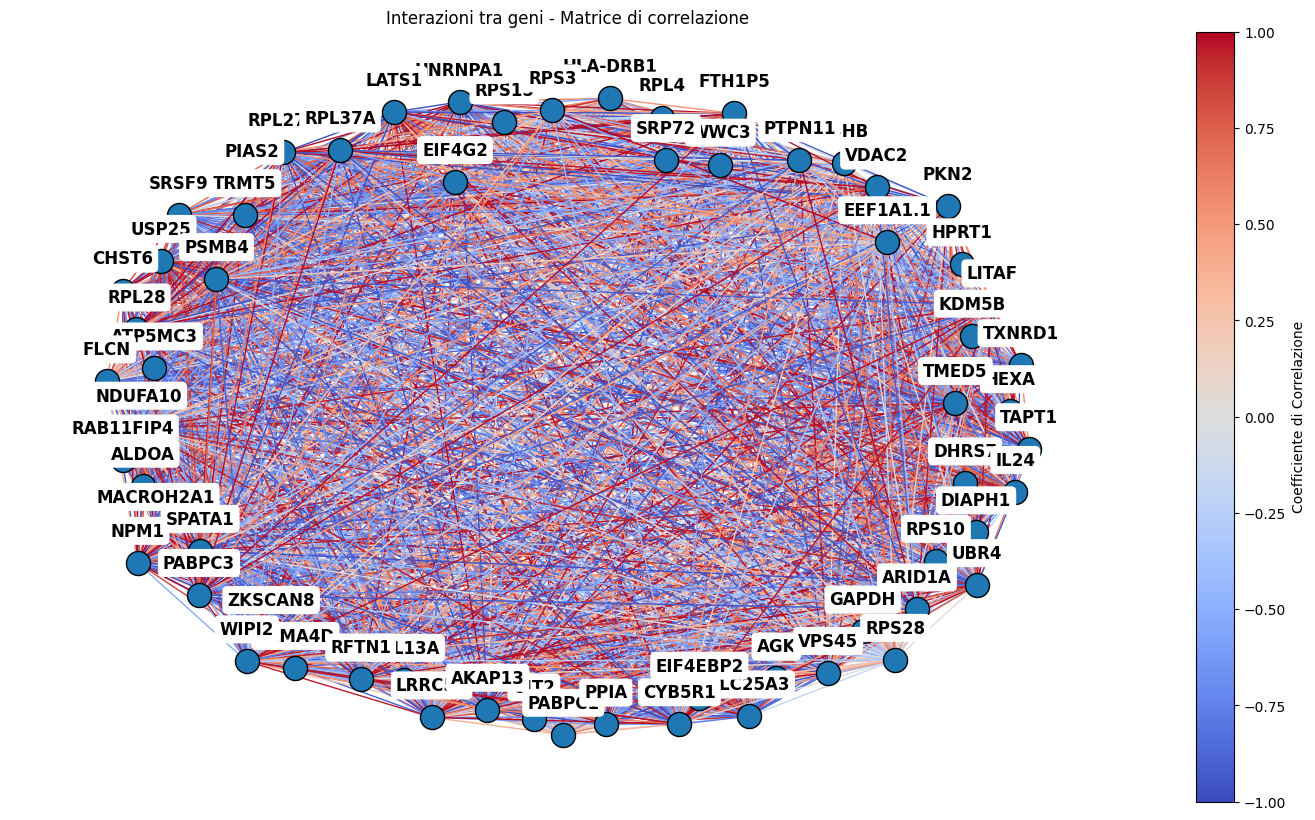

In [7]:
G = nx.Graph()

for i in range(intersectCorr.shape[0]):
    for j in range(intersectCorr.shape[1]):
        if i != j:
            G.add_edge(intersectCorr.columns[i], intersectCorr.columns[j], weight = intersectCorr.iloc[i, j])

weights = nx.get_edge_attributes(G, 'weight').values()
norm = plt.Normalize(-1, 1)
colors = [cm.coolwarm(norm(w)) for w in weights]

pos = nx.spring_layout(G, k=4)
fig, ax = plt.subplots(figsize=(18,10))

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.1) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# Disegna gli archi
nx.draw_networkx_edges(G, pos, ax=ax, edge_color=colors)

# Aggiungi la barra dei colori
sm = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="Coefficiente di Correlazione")
plt.title('Interazioni tra geni - Matrice di correlazione')
plt.axis('off')
plt.show()